In [427]:
import numpy as np 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from summarytools import dfSummary
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import string  
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Bidirectional, LeakyReLU
from sklearn.metrics import f1_score
import keras.backend as K
from keras.optimizers import Adam

### GitHub

**GitHub link**: https://github.com/Ofleitman/ML3_Week4/blob/main/Week_4.ipynb

**Kaggle Dataset**: https://www.kaggle.com/c/nlp-getting-started/overview

**Kaggle Dataset Title**: *Natural Language Processing with Disaster Tweets*

Addison Howard and devrishi and Phil Culliton and Yufeng Guo. (2019). Natural Language Processing with Disaster Tweets. Kaggle. https://kaggle.com/competitions/nlp-getting-started

## Machine Learning 3: Natural Language Processing with Disaster Tweets

### Step 1: Brief description of the problem and data:

**Description of project**: The purpose of this analysis is to develop an NLP model leveraging deep learning techniques, specifically, RNN to classify which of the thousands of tweets that were hand classified, are about real disasters vs. which one's are not.

**Desciption of size, dimension, structure of data**: The training set has a total of 7,613 samples. The **dimensions** of the data set include id, text, and target. Id is a unique identifier, text is the actual tweet that contains text data, and target is the binary label which indicates whether the tweet is about a disaster (1) or not (0). The **structure** of the data is in CSV format. The text of each tweet is likely to contain hashtags, emojis, links, and special characters which may require preprocessing before heading to the model step.

In [428]:
# load data
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_sample = pd.read_csv("data/sample_submission.csv")

In [3]:
df_train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_test.head(5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
df_sample.head(5)

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### Step 2: Exploratory Data Analysis (EDA) - Inspect, Visualize and Clean the Data

I visualized the data via countplot leveraging seaborn library for the training set. It looks like the data is moderately balanced, although we do have non-disaster tweets that are dominating before applying the cleaning step. Moreover, I produced a word cloud to visualize the popular words before applying the cleaning step to get an idea of what the data looks like. Lastly, I produced a histogram to visualize the distribution of how many words per tweet. The word length per tweet is fairly normally distributed with the majority of tweets comprising of about 10 to 20 words.

<Axes: xlabel='target', ylabel='count'>

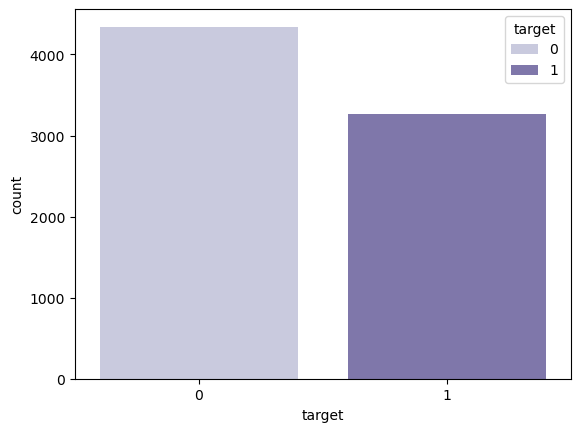

In [36]:
sns.countplot(x='target', data=df_train, hue='target', palette = 'Purples')

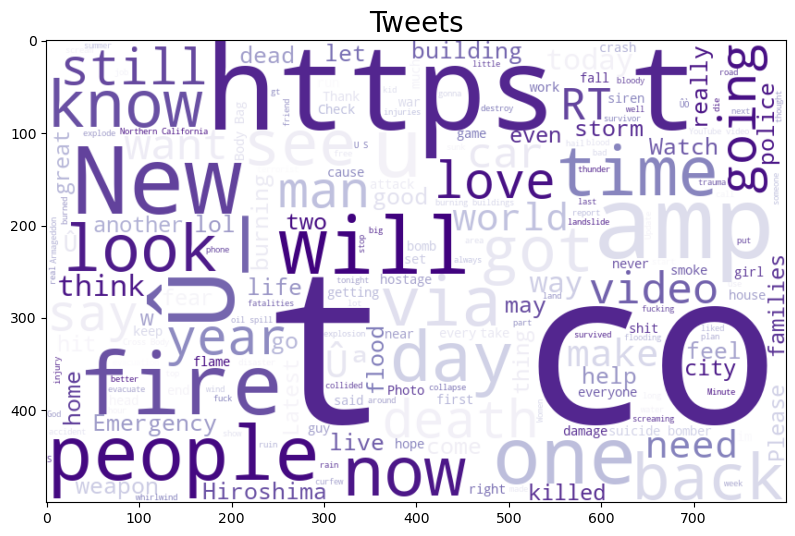

In [60]:
text = ' '.join(df_train.text)
wc = WordCloud(width = 800, height = 500, background_color = 'white', colormap = 'Purples').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wc, interpolation='bilinear')
plt.title('Tweets', fontsize=20)
plt.show()

In [58]:
tweet_length=[]
for i in range(len(df_train.text)):
    tweet_length.append(len(df_train.text[i].split(' ')))

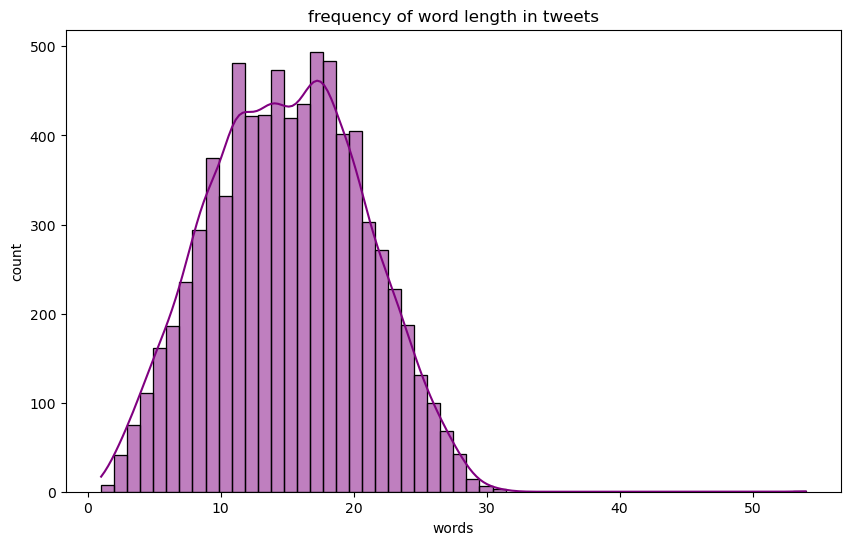

In [87]:
plt.figure(figsize=(10,6))
sns.histplot(tweet_length, color='purple',bins=max(tweet_length),kde=True)
plt.ylabel('count')
plt.xlabel('words')
plt.title('frequency of word length in tweets')
plt.show()

### Data Cleaning

After visualizing the data and reviewing the dfSummary below, I noticed there are many missing values. Given our data is decently large, I decided to completely drop entire rows that have a missing data element instead of trying to interepret what those missing values could be. It is important to mention that the majority of hte missing values are related to location. ~2,500 locations are missing from the dataset. After cleaning for missing values, I am left with a sample size of 5,080.

Additionally, I leveraged the NLTK library to clean-up the tweets by leveraging a function I created for another project I did on classifying news articles from Machine Learning 2: Unsupervised Learning in Week 4. I did have to tweak the function slightly to include the cleaning of links such as `http://`. Once I have cleaned the training set and removed empty rows, the next step was to pre-process the data and ready it for the model step. I decided to leverage TF-IDF methodology which can be utilized for understanding how important a word is to a string of text. It helps idetify relevance. However, the RNN LSTM model I have chosen would not take the TF-IDF vectors directly. After researching online, it was apparent that I required to re-shape the transformations from TL-IDF so that I can compile it into the RNN LSTM model before fitting. This required pre-processing the data before the model step takes place.

In [8]:
dfSummary(df_train)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,id[int64],Mean (sd) : 5441.9 (3137.1)min < med < max:1.0 < 5408.0 < 10873.0IQR (CV) : 5412.0 (1.7),"7,613 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACsElEQVR4nO3ZsU8aYRjH8ecFNS9i74JQ3Fg6mnQgcXHp1rF/bNduNcGks0OXTi7GhJxHuEo4D7rYhMEo73so/OL3s+rj+/ryfQ+MbrlcGrDrGtveALCOvW1vYFc551pmdhA5Pl8ul/eb3M97R6hPcM61ut3utyRJOjHzk8kkc859f2+xvublJtSnHSRJ0jk/P79P03QWMpjnuR+NRp3xeHxgZu8m1Ne+3Dsd6rbfftM0nfX7/b+hc1VVJWaWOOdilq217y2e2ate7hdDrfmLN8xsETnrj4+Pv6Zp2o4Zvru7mzrnfphZ0KE9ShaLxX7MukVR7Jdl+XkwGDSbzWbw2jX3XevMNvGRJfZym1nruS8+G2qdx3lVVftFUXw6Ojr602g0ytD5siy9mZ2enZ396vV6k5DZm5ubD5eXl18Gg0EvJpayLH1VVaez2eynmQUd+nw+3/PeHw6Hw9nJyUkWMruJfVvkmeV57i8uLvrj8bjnnAuafRR9udfx0hM1+nF+fX3dubq6+jgcDn+HvmAr84fe+zL0hmZZ1oqNZXXth4eHZujsf+12O/jJsql9x5xZ3XeCOpd7HWt9Ro15nGdZ1jKLe8FW5+vY5tp1bGPfdd4JzDZzuZ+z039M4e3t6uXmP1OQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQsLfON+V57kN/8HQ69WZmRVH429vbw7ecV11bdd9159fp6x+7EGq+/opZmQAAAABJRU5ErkJggg=="">",0(0.0%)
2,keyword[object],1. nan2. fatalities3. deluge4. armageddon5. sinking6. damage7. harm8. body%20bags9. evacuate10. fear11. other,"61 (0.8%)45 (0.6%)42 (0.6%)42 (0.6%)41 (0.5%)41 (0.5%)41 (0.5%)41 (0.5%)40 (0.5%)40 (0.5%)7,179 (94.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADfElEQVR4nO3cMW4aUQBF0Y+FrLgZhJBYDIvwYrMIdoMQU8SWG1KElA6Wk1wUck6VIsUUV8Pk678szufzgMLDrR+A/4fYyIiNjNjIiI2M2MiIjYzYyIiNzGKM8TTGGOfz+eXGz8KdW242m+cxxlgsFl8Fx9/0ME3Tepqm9Rjj8dYPw33zzUZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZJbzPB8vf3676ZNw92wQyCz8l1lUvNnIWFeRsa4i4+iDjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2MwQsZ18LJGLyQ8WYjY/BCxuCFjKMPMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kXAsnY/BCxjcbGT+jZKyryFhXkfHNRkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGxrqKjGvhZKyryHizkTF4IWPwQsbRBxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGYMXMq6FkzF4IePNRsbghYzBCxlHH2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGxrqKjA0CGesqMt5sZKyryFhXkXH0QUZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGxuCFjGvhZAxeyHizkTF4IWPwQsbRBxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGYMXMq6FkzF4IeObjYyfUTLWVWSsq8j4ZiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiI2NdRca1cDLWVWS82cgYvJAxeCHj6IOM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxnXwskYvJD5+WZzJZzf9Xbt13G52WyeLxsE+LR5no/XRlPLaZrWu93uZbVavZYPx/04nU5f9vv9+nA4PI4x3o9tjDFWq9Xrdrv9lj0d9+jp2l9wzkZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZmOcaPKyK3fhD+XR/tZznP83G/36/HB66IwHsuw6lfjqZcC+dPuXot3OCFjH8gkBEbGbGRERsZsZERGxmxkREbGbGR+Q6r/BAn38TSMAAAAABJRU5ErkJggg=="">",61(0.8%)
3,location[object],"1. nan2. USA3. New York4. United States5. London6. Canada7. Nigeria8. UK9. Los Angeles, CA10. India11. other","2,533 (33.3%)104 (1.4%)71 (0.9%)50 (0.7%)45 (0.6%)29 (0.4%)28 (0.4%)27 (0.4%)26 (0.3%)24 (0.3%)4,676 (61.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAEMUlEQVR4nO3dzW1bVxhF0Y8EYVsTEgQBlZDMXICKcLEpggV4mB4EQW9gOZ4oA8tBAGcWaT+DXKuCa2Hj8Qf3mJvn5+eBwnbtA3A9xEZGbGTERkZsZMRGRmxkxEZGbGQ2M3MzM+/WPsgr+vb8/Py09iH42e50On3a7/fHtQ/yWpZledhsNn8I7tez2+/3x7u7u6fD4fB17cP8X4+Pjx/O5/Px/v7+3cyI7Rezm5k5HA5fb29vv6x9mFdys/YB+G8+IJARGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERG5ndzPd7YGsf5DVcyr/jUu2WZXk4n8/HuZB7YMuyPMzMt7XPwc9sEMhs/JdZVP79ZPNE4E39s66ySuKtbff7/fHjx4/zMue7pPdu/GK2MzM3Nzd/rX0QLp8vdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MhsZ2aenp7er30QLt92WZaHz58/G4rw5lwLJ2PwQubHk2081Xhru9Pp9GlmxtiFt7bd

In [9]:
df_cleaned = df_train.dropna()

In [11]:
dfSummary(df_cleaned)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,id[int64],Mean (sd) : 5407.1 (3116.4)min < med < max:48.0 < 5360.5 < 10833.0IQR (CV) : 5357.2 (1.7),"5,080 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACo0lEQVR4nO3ZsW7aUBiG4e9AQCZJjRAt2Vg6VurAyNI76MV27ZYhuYEMXTqxRJGQQ4QbhGPo1EpdCD4O4E99n7X5a8t+feLjhO12K6DpWqc+AWAfZ6c+gV1CCD1J3cjx9Xa7fX7L88HpNDbUEEJvOBx+TdN0EDP/9PSUhRC+EevxHHJhaWyokrppmg6m0+lzv99fVRlcLBbJzc3NYD6fdyUR6hEcemFpcqiSpH6/vxqNRr+qzpVlmUpKQwixh25J2kTO/o+vHQddWF4N1fE9Mc/zTlEUn8fjcbvdble6aJJUlmUnz/OPl5eXP1utVlF1/vHxcRlC+C6p8rFV7wGRTvyQxC4sknq7/nFnqHWX85o3LN1sNp2Y467X67MkSc4nk8nq6uoqqzo/m80Gd3d3HyaTyY+q8/f39+9ub2+/jMfj91UfkroPiFT7mjf2N8FrK2r0cl7nhklSURRJWZafVqvVtaSYJ1QXFxdRT3eWZb3Y+SzLerEPSZ0HRKp/zZu8Ad3rHTVmOa9zw6S/N+385eWlXXW2CWIjj539Mx97zZu+AT34ZqruqobqYq+5XnlPPCX+MgULjf88heMpy7Kj+E960ZvffRAqJNX/pPcWm99dCBWS3uyT3sE2v4SKfzR188tmChYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRYIFRbO9vmhxWKRVP2Pl8tlIkl5nicPDw/nx5x3Pbbreded36ev36kke08xwY1zAAAAAElFTkSuQmCC"">",0(0.0%)
2,keyword[object],1. collision2. whirlwind3. armageddon4. fatalities5. flames6. emergency%20plan7. derailed8. outbreak9. sandstorm10. danger11. other,"36 (0.7%)33 (0.6%)32 (0.6%)32 (0.6%)31 (0.6%)31 (0.6%)31 (0.6%)31 (0.6%)31 (0.6%)30 (0.6%)4,762 (93.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADfUlEQVR4nO3cPW4TUQBG0efIikgzlmXJi/EislgW4d1YlqcgUZqhIDQUYP6uhTmnoqCY4mo8PL2P1bIsAwoPt34A/h9iIyM2MmIjIzYyYiMjNjJiIyM2MqsxxtMYYyzL8nLjZ+HOrXe73fMYY6xWq4+C4296mKZpO03TdozxeOuH4b75ZiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2Mut5ns/vf3676ZNw92wQyKz8l1lUvNnIWFeRsa4i4+iDjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2MwQsZ18LJGLyQ8WYjY/BCxuCFjKMPMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kXAsnY/BCxjcbGT+jZKyryFhXkfHNRkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGxrqKjGvhZKyryHizkTF4IWPwQsbRBxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGYMXMq6FkzF4IePNRsbghYzBCxlHH2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGxrqKjA0CGesqMt5sZKyryFhXkXH0QUZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGxuCFjGvhZAxeyHizkTF4IWPwQsbRBxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGYMXMq6FkzF4IeObjYyfUTLWVWSsq8j4ZiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiI2NdRca1cDLWVWS82cgYvJAxeCHj6IOM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxnXwskYvJD5+mZzJZzf8XbNL+N6t9s9v28Q4JfM83y+ZjC1nqZpezgcXjabzWv1cNyPy+Xy4Xg8bk+n0+MY4/uxjTHGZrN53e/3n5Kn4x49XfOXnLORERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRWY/x5ZrIrR+Ef9PPtLOe5/l8PB6348prIvCt99HUDwdTroXzJ1x1LdzghYx/IJARGxmxkREbGbGRERsZsZERGxmxkfkMN8cQJ9LzEfAAAAAASUVORK5CYII="">",0(0.0%)
3,location[object],"1. USA2. New York3. United States4. London5. Canada6. Nigeria7. UK8. Los Angeles, CA9. India10. Mumbai11. other","104 (2.0%)71 (1.4%)50 (1.0%)45 (0.9%)29 (0.6%)28 (0.6%)27 (0.5%)26 (0.5%)24 (0.5%)22 (0.4%)4,654 (91.6%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAD70lEQVR4nO3cMW5iVwCG0QtCztA8hJC8DC+ARXixWQQL8D4si1cEx41ThBlNl8ESHwpzTufC0i0+PfDT/b34/PwcUFje+gD8PsRGRmxkxEZGbGTERkZsZMRGRmxkFmOM9Rjj4fzzx+fn5+mG5+GOrXa73fM0Tdsxxpjn+W2xWPwpOK5hOU3Tdr/fn/b7/ekc3cN//hZ8wWqMMTabzfv55/UNz8Kd8wcCGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRWY0xxvF4/Hbrg3D/VvM8vx0Ohx83dccYHzc+E3fKBoHMwr/MovLzk81Tjav6sa6yrOLaltM0bZ+enoZlFde2HGOM9Xr9960Pwv3zUpeM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3McowxTqfTH7c+CPdvOc/z28vLi7ELV+daOBmDFzKebGQMXsgYvJAxeCHjpS4ZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9kXAsnY/B

### Tweet example (before text cleaning)

In [128]:
source = df_cleaned

t_idx = 1614
t_id = source.iloc[t_idx]['id']
t_text = source.iloc[t_idx]['text']
t_keyword = source.iloc[t_idx]['keyword']
t_label = source.iloc[t_idx]['target']

print(f"id: {t_id}\n\nkeyowrd: {t_keyword}\n\ntext:\n{t_text} \n\ntarget: {t_label}")

id: 3437

keyowrd: derail

text:
24 killed in two simultaneous rail crash as acute floods derail the two trains #India #mumbai... http://t.co/b0ZwI0qPTU 

target: 1


In [155]:
# source: re-using my clean_up function I created from ML2 Week 4 assignment here with several tweaks
# helper function to preprocess the text
def clean_up(text):
    # convert all text to lower case
    text = text.lower()
    # remove http links
    text = re.sub(r'http\S+|https\S+', '', text)
    # remove symbols, digits, and currency symbols
    text = re.sub(r'\d+', '', text) 
    text = re.sub(r'[\$\£]', '', text)  
    text = re.sub(r'[.\-()\[\]]', '', text) 
    # remove all punctuation
    text = text.translate(str.maketrans("","",string.punctuation))
    # tokenize text
    tokens = word_tokenize(text)
    # remove stop words
    # get list of stop words from NLTK stopwords
    stop_words = set(stopwords.words('english'))
    # initailize empty list that will track the filtered tokens (e.g., removed stopwords)
    filtered_tokens = []
    # run for loop to check each token and only append the words that are not part of NLTK's stopwords
    for each_word in tokens:
        if each_word not in stop_words:
            filtered_tokens.append(each_word)
    # initialize lemmatizer
    lemmatizer = WordNetLemmatizer()
    # initialize empty list to store lemmatized tokens
    lemmatized_tokens = []
    # run for loop to check each filtered token from previous step - lemmatize and add to previously initialized
    # lemmatized list
    for each_word in filtered_tokens:
        lemmatized_tokens.append(lemmatizer.lemmatize(each_word))

    # return lemmatized tokens (individual words) into a single string
    return ' '.join(lemmatized_tokens)

In [156]:
df_cleaned_text = df_cleaned.copy()

In [157]:
df_cleaned_text['clean_text'] = df_cleaned_text['text'].apply(clean_up)

In [158]:
df_cleaned_text

,id,keyword,location,text,target,clean_text
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,bbcmtd wholesale market ablaze
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,always try bring heavy metal rt
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,africanbaze breaking newsnigeria flag set abla...
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,cry set ablaze
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,plus side look sky last night ablaze
...,...,...,...,...,...,...
7575,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0,bright side wrecked
7577,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0,widda he gone relax thought wife wrecked cake ...
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0,three day work theyve pretty much wrecked haha...
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0,fx forex trading cramer igers word wrecked dis...


### Tweet example (after text cleaning)

In [163]:
source = df_cleaned_text

t_idx = 1614
t_id = source.iloc[t_idx]['id']
t_text = source.iloc[t_idx]['clean_text']
t_keyword = source.iloc[t_idx]['keyword']
t_label = source.iloc[t_idx]['target']

print(f"id: {t_id}\n\nkeyowrd: {t_keyword}\n\ntext:\n{t_text} \n\ntarget: {t_label}")

id: 3437

keyowrd: derail

text:
killed two simultaneous rail crash acute flood derail two train india mumbai 

target: 1


### Data preprocessing

I preprocessed the data leveraging TF-IDF and reshape so that it would work with RNN sequential deep learning LSTM model layer.

In [164]:
X_train, X_val, y_train, y_val = train_test_split(df_cleaned_text['clean_text'], df_cleaned_text['target'], test_size=0.2, random_state=42)

In [175]:
# source - leveraged code from ML2 Week 4 to implement TfidVectorizer on clean text
# initialize TF_IDF vectorizer
tfidf_vec = TfidfVectorizer()
# fit and transform the cleaned text into a matrix
tfidf_m_train = tfidf_vec.fit_transform(X_train)
tfidf_m_test = tfidf_vec.transform(X_val)
# convert the TF_IDF matrix into a df for ease of use
tfidf_df_train = pd.DataFrame(tfidf_m_train.toarray(),columns=tfidf_vec.get_feature_names_out())
tfidf_df_test = pd.DataFrame(tfidf_m_test.toarray(),columns=tfidf_vec.get_feature_names_out())
print(tfidf_df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4064 entries, 0 to 4063
Columns: 10521 entries, aa to ûónegligence
dtypes: float64(10521)
memory usage: 326.2 MB
None


### Step 3: Model Architecture

To build and train a sequential neural network model for processing Tweets related to disasters and classify them whether they are related to true disasters, I have decided to clean and pre-process the data leveraging the NLTK library as outlined earlier. Before architecting the model, I created a helper function called `f1`. The idea behind this is so that I can fit this as one of the metrics to report as I fit the models I compile. It would help me better understand the model's performance earlier and make the necessary tweaks before waiting for the model to finish completely. The reason I chose F1 Score is twofold. First, F1 is a better measure than accuracy alone. F1 actually takes both precision and recall into account. Second, the Kaggle competition will be evaluated based on the F1 score, so that was my focus.

After the `f1` function was created I focused on producing a base LSTM model. The sequence is fiarly simple, I use an LSM layer of 100, a dense layer with relu activation and sigmoid as the output layer since this is a binary classification problem. I used adam as the optimizer without tinkering with a custom learning rate. Finally, I wrapped model by adding the f1 metric in the compile step.

After having the base model fitted, I pivoted my focus to hyperparameter tuning a second model based off of the previous model. I have increased the LSTM to 500 to retain more complex patterns. However, with a higher LSTM such as 500, I realized that I run the risk of overfitting the model. To combat this I included dropout and recurrent_dropout hyperparameters. The dropout acts as a regularization technique. I understand that it works by randomly dropping a fraction of the input units to 0 so that not one feature is heavily relied on. Recurrent dropout is a similar concept to dropout, however, it applies to the connections within the LSTM layer itself. Both dropout and recurrent_dropout are ways we can help prevent the model from overfitting given the higher units (500) chosen earlier. I have also changed `return_sequences` to True from False. This is most useful when stacking multiple LSTM steps. I had experimented with multiple LSTM steps before reverting to simplify to one for the tuned model approach. Next, Leaky ReLU activation follows before the output layer. The idea I had here is to help with potentially exploding gradient issue. I understand it helps mitigate a situation when nuerons stop learning because of the vanishing gradients. Lastly, I have optimized the learning rate to 0.0001 for Adam compiling the model before fitting.

### F1 helper function

Since the competition is evaluated from the perspective of F1 score, the helper function below will be implemented when we compile the model as a custom metric to include while we train the each model.

In [186]:
# f1 helper function to incorporate as we train our model
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    return 2 * (K.mean(y_true * y_pred) / (K.mean(y_true) + K.mean(y_pred)))

### Base LSTM model

In [342]:
# ready TF-IDF for RNN model as inputs
X_train_tfidf = tfidf_m_train.toarray()
X_val_tfidf = tfidf_m_test.toarray()

# reshape for LSTM
X_train_lstm = X_train_tfidf.reshape(X_train_tfidf.shape[0], 1, X_train_tfidf.shape[1])
X_val_lstm = X_val_tfidf.reshape(X_val_tfidf.shape[0], 1, X_val_tfidf.shape[1])

# to clear session everytime we run this to begin from session 0
K.clear_session()

# model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=False))
model.add(Dense(64,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

#compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               4248800   
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4255329 (16.23 MB)
Trainable params: 4255329 (16.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [344]:
history=model.fit(X_train_lstm, y_train, epochs=5, batch_size=64, validation_data=(X_val_lstm, y_val))

Epoch 1/5
64/64 [==============================] - 2s 36ms/step - loss: 0.0502 - accuracy: 0.9811 - f1: 0.9781 - val_loss: 0.7806 - val_accuracy: 0.7589 - val_f1: 0.7211
Epoch 2/5
64/64 [==============================] - 2s 36ms/step - loss: 0.0434 - accuracy: 0.9835 - f1: 0.9797 - val_loss: 0.8154 - val_accuracy: 0.7648 - val_f1: 0.7234
Epoch 3/5
64/64 [==============================] - 2s 36ms/step - loss: 0.0421 - accuracy: 0.9818 - f1: 0.9790 - val_loss: 0.8711 - val_accuracy: 0.7411 - val_f1: 0.7126
Epoch 4/5
64/64 [==============================] - 2s 38ms/step - loss: 0.0367 - accuracy: 0.9843 - f1: 0.9817 - val_loss: 0.8861 - val_accuracy: 0.7500 - val_f1: 0.7190
Epoch 5/5
64/64 [==============================] - 2s 36ms/step - loss: 0.0379 - accuracy: 0.9820 - f1: 0.9786 - val_loss: 0.8772 - val_accuracy: 0.7667 - val_f1: 0.7244


### Hyperparameter Tuned LSTM model

In [349]:
# to clear session everytime we run this to begin from session 0
K.clear_session()

# model
tuned_model = Sequential()
tuned_model.add(LSTM(500, 
                     input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), 
                     dropout = 0.1,
                     recurrent_dropout=0.1,
                     return_sequences=True))
tuned_model.add(Dense(64,activation='relu'))
tuned_model.add(LeakyReLU(alpha=0.1))
tuned_model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
tuned_model.summary()

#compile model
tuned_model.compile(loss='binary_crossentropy',  optimizer=Adam(learning_rate=0.0001), metrics=['accuracy', f1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 500)            22044000  
                                                                 
 dense (Dense)               (None, 1, 64)             32064     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1, 64)             0         
                                                                 
 dense_1 (Dense)             (None, 1, 1)              65        
                                                                 
Total params: 22076129 (84.21 MB)
Trainable params: 22076129 (84.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [351]:
history_tuned=tuned_model.fit(X_train_lstm, y_train, epochs=5, batch_size=64, validation_data=(X_val_lstm, y_val))

Epoch 1/5
64/64 [==============================] - 13s 204ms/step - loss: 0.4077 - accuracy: 0.9085 - f1: 0.8851 - val_loss: 0.4813 - val_accuracy: 0.8061 - val_f1: 0.7463
Epoch 2/5
64/64 [==============================] - 13s 205ms/step - loss: 0.3330 - accuracy: 0.9222 - f1: 0.9033 - val_loss: 0.4579 - val_accuracy: 0.8022 - val_f1: 0.7542
Epoch 3/5
64/64 [==============================] - 13s 205ms/step - loss: 0.2712 - accuracy: 0.9341 - f1: 0.9198 - val_loss: 0.4516 - val_accuracy: 0.7943 - val_f1: 0.7539
Epoch 4/5
64/64 [==============================] - 13s 205ms/step - loss: 0.2277 - accuracy: 0.9454 - f1: 0.9345 - val_loss: 0.4488 - val_accuracy: 0.7972 - val_f1: 0.7557
Epoch 5/5
64/64 [==============================] - 13s 206ms/step - loss: 0.1939 - accuracy: 0.9525 - f1: 0.9425 - val_loss: 0.4521 - val_accuracy: 0.7972 - val_f1: 0.7519


### Step 4: Results and Analysis

As outlined in the previous section, I architected a base and hyperparameter tuned model. I produced a summary table below of each models performance in terms of accuracy, validation accuracy, F1 Score, and validation F1 Score. The base model was a simple sequential model with LSTM layer and output layer. It performed fairly well. However, do note, the reason this model performed well out of the box is because alot of work was done in the cleaning and preprocessing step. Since the Kaggle competition is evaluated based on F1 score, a function was created to include that in the model compile step. Further, I produced two plots to better visualize the accuracy and F1 scores.

In the accuracy plot, although the base model had a higher accuracy, for the same number of epochs, we can see that the tuned model was catching up on the fifth epoch. Also note, that the minor sacrifice in accuracy in the tuned model helped it better generalize compared to that of the base model. This is evident when reviewing the validation accuracy lines. The tuned model performed better with new data then the base model. It has also a more stable performnace across each of the epochs. This is likely do to the fact that we leveraged regularization techniques as outlined in the previous section.

In the F1 Score plot, we see similar results as we have in the accuracy plot. The F1 Score on training data is higher for the base model, however, the tuned model generalizes better; thus, has a better performance on new data.

Lastly, I packaged cleaned and preprocessed the test set in the same manner I did the training set. I fed the test set through both the base and tuned models and submitted the results to Kaggle. As expected, the tuned model had an edge over the base model. In fact the tuned model produced a score of ~0.78 while the base model produced a score of ~0.75.

In [383]:
# base model metrics
base_acc = history.history['accuracy']
base_val_acc = history.history['val_accuracy']
base_f1 = history.history['f1']
base_val_f1 = history.history['val_f1']

# tuned model metrics
tuned_acc = history_tuned.history['accuracy']
tuned_val_acc = history_tuned.history['val_accuracy']
tuned_f1 = history_tuned.history['f1']
tuned_val_f1 = history_tuned.history['val_f1']

In [391]:
# store results from models history based on the last epoch in a dictionary format
res = {
    'Metric': ['Accuracy', 'Validation Accuracy', 'F1 Score', 'Validation F1 Score'],
    'Base Model': [base_acc[-1], base_val_acc[-1], base_f1[-1], base_val_f1[-1]],
    'Tuned Model': [tuned_acc[-1], tuned_val_acc[-1], tuned_f1[-1], tuned_val_f1[-1]]
}

# convert results to pd df
res_df = pd.DataFrame(res)

# print results
res_df

,Metric,Base Model,Tuned Model
0,Accuracy,0.982037,0.952510
1,Validation Accuracy,0.766732,0.797244
2,F1 Score,0.978562,0.942450
3,Validation F1 Score,0.724378,0.751905


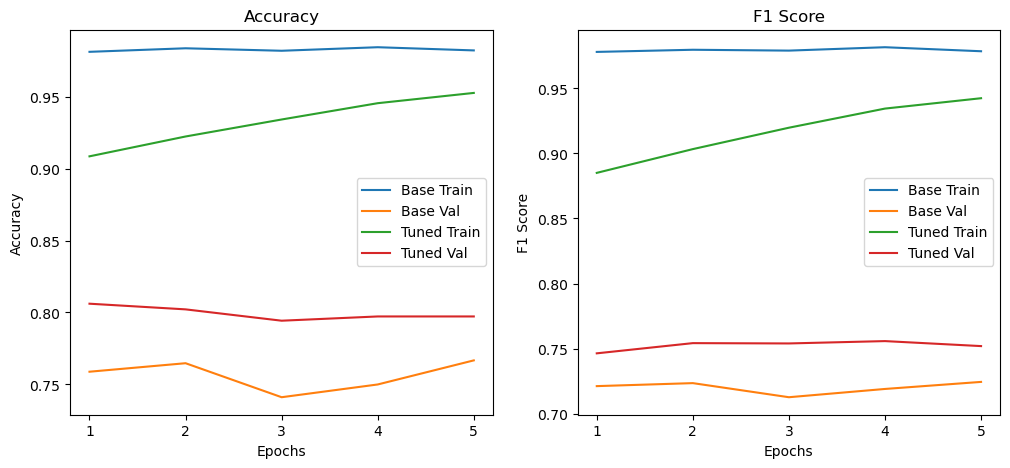

In [426]:
epochs = range(1, 6)

# plot accuracy results of both base model and tuned model
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, base_acc, label='Base Train')
plt.plot(epochs, base_val_acc, label='Base Val')
plt.plot(epochs, tuned_acc, label='Tuned Train')
plt.plot(epochs, tuned_val_acc, label='Tuned Val')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1,6,1))
plt.legend()

# plot F1 score results of both base model and tuned model
plt.subplot(1, 2, 2)
plt.plot(epochs, base_f1, label='Base Train')
plt.plot(epochs, base_val_f1, label='Base Val')
plt.plot(epochs, tuned_f1, label='Tuned Train')
plt.plot(epochs, tuned_val_f1, label='Tuned Val')
plt.title('F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.xticks(range(1,6,1))
plt.legend()

### Submission file

In [352]:
test_clean = df_test.copy()
test_clean = test_clean.drop(columns=['keyword','location'])
test_clean['clean_text'] = test_clean['text'].apply(clean_up)
test_clean = test_clean.drop(columns=['text'])
#transform the cleaned test text into a matrix
tfidf_m_submission = tfidf_vec.transform(test_clean.clean_text)
# convert TF-IDF matrix to array
test_submission = tfidf_m_submission.toarray()
# reshape for LSTM
tfidf_df_submission = test_submission.reshape(test_submission.shape[0], 1, test_submission.shape[1])

In [353]:
pred_base = model.predict(tfidf_df_submission)
pred_tuned = tuned_model.predict(tfidf_df_submission)

102/102 [==============================] - 2s 22ms/step


In [365]:
pred_labels_model = (pred_base > 0.5).astype(int)
pred_labels_tuned_model = (pred_tuned > 0.5).astype(int)

In [376]:
model_base = test_clean.copy()
model_base = model_base.drop(columns=['clean_text'])
model_base['target'] = pred_labels_model

In [382]:
model_base.to_csv('submission_base.csv',index=False)

In [378]:
model_tuned = test_clean.copy()
model_tuned = model_tuned.drop(columns=['clean_text'])
model_tuned.reset_index(drop=True, inplace=True)
model_tuned['target'] = pred_labels_tuned_model.flatten()

In [381]:
model_tuned.to_csv('submission_tuned.csv',index=False)

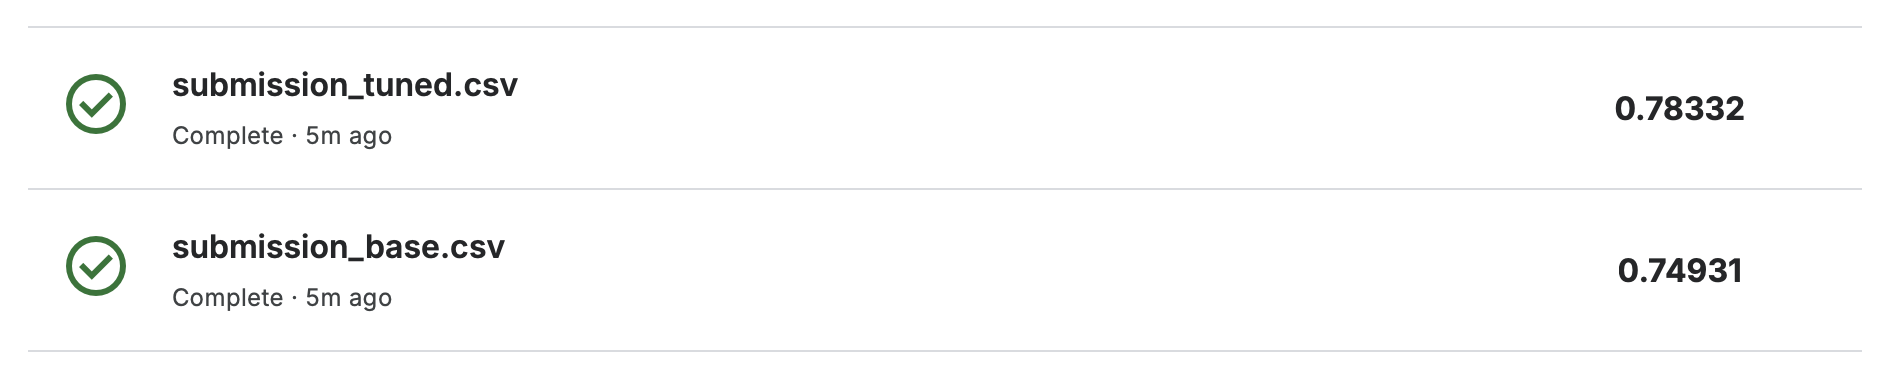

### Step 5: Conclusion

Interpretation of results were outlined in the previous section. Some of the key takeaways and learnings I came across include understanding how to layer LSTM within a sequential model, how to preprocess and reshape TF-IDF vectors to make it compatible with the LSTM layer, and different hyperparameters available within LSTM layer. For example, feeding TF-IDF vectors into LSTM did not work. After researching, I discovered that TF-IDF needs to be pre processed and reshaped in order for them to correctly feed into LSTM model. Further, I learned about various hyperparameters that can be tuned within the LSTM layer such as `dropout` and `recurrent_dropout` hyperparameters. I tried adding multiple LSTM layers to see whether the model performance will improve and it did not so I reverted back to 1 LSTM layer for simplicity. For the future, perhaps, we can run the model without dropping null values across the entire dataset. This will enable us to have more training data and potentially better performance. I did not utilize the other columns as I thought I would. However, this brings me to my last point. Perhaps, we could leverage the keyword column to identify which keywords the model is struggling to identify whether a Tweet is a real disaster. We can then try and see if we can have the model train better on those aspects to improve model robustness.

### References
https://www.kaggle.com/c/nlp-getting-started/overview <br>
https://kaggle.com/competitions/nlp-getting-started
https://numpy.org/doc/stable/ <br> 
https://pandas.pydata.org/pandas-docs/stable/ <br> 
https://numpy.org/doc/stable/ <br> 
https://matplotlib.org/stable/contents.html <br> 
https://seaborn.pydata.org/ <br> 
https://pypi.org/project/summarytools/ <br> 
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html <br> https://keras.io/api/preprocessing/text/#tokenizer-class <br> 
https://keras.io/api/preprocessing/text/#pad_sequences-function <br> 
https://keras.io/api/models/sequential/ <br> 
https://keras.io/api/layers/core_layers/embedding/ <br> 
https://keras.io/api/layers/recurrent_layers/lstm/ <br> 
https://keras.io/api/layers/core_layers/dense/ <br> 
https://keras.io/api/layers/core_layers/dropout/ <br> 
https://wordcloud.readthedocs.io/en/latest/ <br> 
https://www.nltk.org/api/nltk.tokenize.html <br> 
https://www.nltk.org/api/nltk.corpus.html <br> 
https://docs.python.org/3/library/re.html <br> 
https://docs.python.org/3/library/string.html <br> 
https://www.nltk.org/api/nltk.stem.html <br> 
https://www.nltk.org/api/nltk.corpus.html <br> 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html <br> https://keras.io/api/models/sequential/ <br> 
https://keras.io/api/layers/core_layers/dense/ <br> 
https://keras.io/api/layers/core_layers/dropout/ <br> 
https://keras.io/api/layers/recurrent_layers/bidirectional/ <br> 
https://keras.io/api/layers/advanced_activation_layers/leakyrelu/ <br> 
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html <br> 
https://keras.io/backend/ <br> https://keras.io/api/optimizers/adam/ <br>